In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve

import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [26]:
categorical_columns=list(df.columns[df.dtypes=='object'])
numerical_columns=list(df.columns[df.dtypes!='object'])
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [27]:
df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(0)
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [28]:
df_fulltrain,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_fulltrain,test_size=0.25,random_state=1)
y_train = df_train['converted']
y_val = df_val['converted']
y_test= df_test['converted']

del df_train['converted']
del df_val['converted']
del df_test['converted']
if 'converted' in numerical_columns:
    numerical_columns.remove('converted')

In [29]:
sum_of_df = len(df_test)+len(df_train)+len(df_val)
print(sum_of_df,len(df))
assert len(df) == sum_of_df

1462 1462


In [30]:
#calculate roc_auc_score for numerical values
for i in numerical_columns:
  score=roc_auc_score(y_train,df_train[i])
  print(i,score)

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


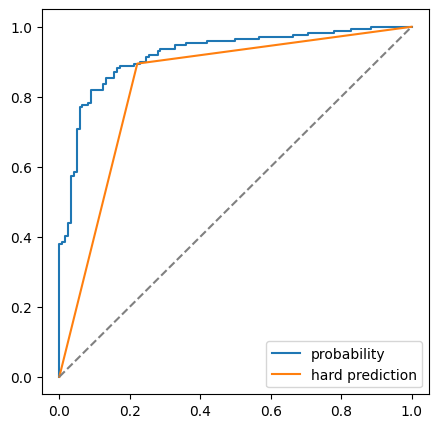

In [31]:
X_train_num=df_train[numerical_columns].values
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
ohe = OneHotEncoder(sparse_output=False)
X_train_cat = ohe.fit_transform(df_train[categorical_columns].values)
X_train = np.column_stack([X_train_cat,X_train_num])
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)
X_val_num=df_val[numerical_columns].values
X_val_num = scaler.transform(X_val_num)
X_val_cat = ohe.transform(df_val[categorical_columns].values)
X_val = np.column_stack([X_val_cat,X_val_num])
y_pred =model.predict_proba(X_val)[:,1]
#accuracy_score(y_val,y_pred>=0.5)
roc_auc_score(y_val,y_pred)
y_pred_bin = model.predict(X_val)
#accuracy_score(y_val,y_pred)

#@ INSPECTING THE ROC CURVE:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()


threshold    0.530000
p            0.877907
r            0.883041
diff         0.005134
f1           0.880466
Name: 53, dtype: float64
threshold    0.530000
p            0.877907
r            0.883041
diff         0.005134
f1           0.880466
Name: 53, dtype: float64


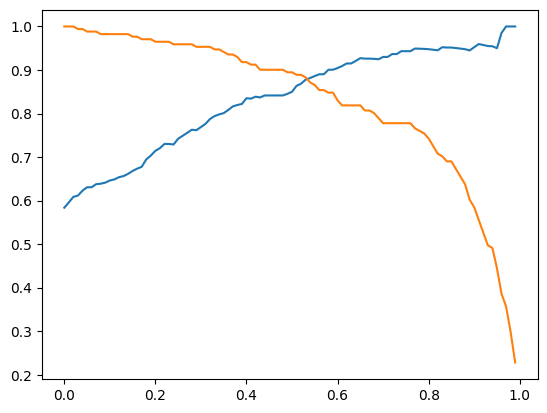

In [32]:
scores =[]
columns = ['threshold','p','r','diff','f1']
df_scores = pd.DataFrame(scores,columns=columns)
thresholds = np.arange(0,1.01,0.01)
for t in thresholds:
    y_pred_n = ( y_pred>= t).astype(int)
    if y_pred_n.sum() ==0:
       continue
    p = precision_score(y_val,y_pred_n)
    r = recall_score(y_val,y_pred_n)
    d = abs(p-r)
    f1 = 2*((p*r)/(p+r))
    scores.append((t,p,r,d,f1))
    
df_scores = pd.DataFrame(scores,columns=columns)
print(df_scores.iloc[df_scores['diff'].idxmin()])
print(df_scores.iloc[df_scores['f1'].idxmax()])
#df_scores['f1'].max()
plt.plot(df_scores.threshold,df_scores['p'],label ='Precision')
plt.plot(df_scores.threshold,df_scores['r'],label ='Recall')
#plt.legend()



In [36]:
scores = []
no_of_splits =5
kfold=KFold(no_of_splits ,shuffle=True, random_state=1)
for c in [0.000001, 0.001, 1]:
    scores = []
    for train_idx,val_idx in kfold.split(df_fulltrain):
        df_train =df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]
        y_train = df_train.converted
        y_val = df_val.converted
        model =train(df_train,y_train,c)
        X_val_num=df_val[numerical_columns].values
        X_val_num = scaler.transform(X_val_num)
        X_val_cat = ohe.transform(df_val[categorical_columns].values)
        X_val = np.column_stack([X_val_cat,X_val_num])
        y_pred = model.predict(X_val)
        roc = roc_auc_score(y_val,y_pred)
        scores.append(round(roc,2))
    print(c,round(np.mean(scores),3),np.std(scores))
    

1e-06 0.766 0.016248076809271934
0.001 0.786 0.024166091947189133
1 0.84 0.024494897427831768


In [35]:
def train(df_train,y_train,C=c):
    X_train_num=df_train[numerical_columns].values
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    ohe = OneHotEncoder(sparse_output=False)
    X_train_cat = ohe.fit_transform(df_train[categorical_columns].values)
    X_train = np.column_stack([X_train_cat,X_train_num])
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train,y_train)
    return model